<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_linear_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

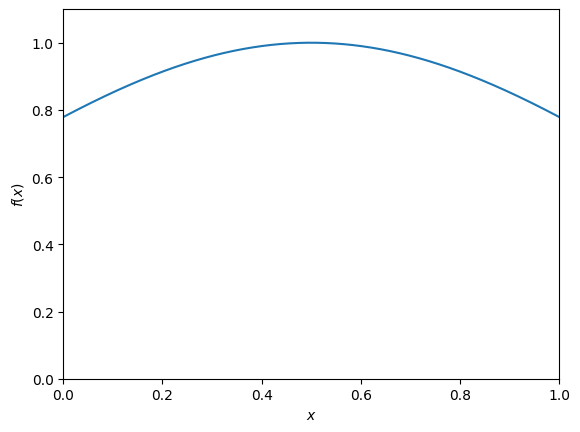

In [ ]:
def f(x):
  return torch.exp(-(x-0.5)**2)

xs = torch.linspace(0, 1, 10000)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

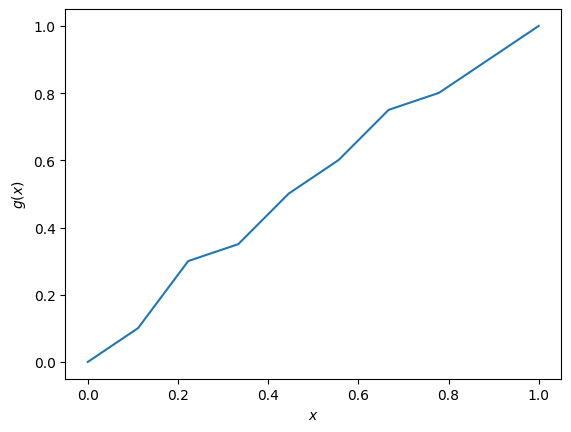

In [ ]:
def g(x, y_params):   #piecewise linear transform with K bins

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct bin indices i for each x value
  i_values = torch.clamp((x * K).long(), max=K-1)

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values+1]
  y_left = ys[i_values]
  y_right = ys[i_values+1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

#test plot
test_params = torch.tensor([0.1, 0.3, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9])
test_g = g(xs, test_params)
plt.plot(xs, test_g)
plt.xlabel('$x$')
plt.ylabel('$g(x)$')
plt.show()

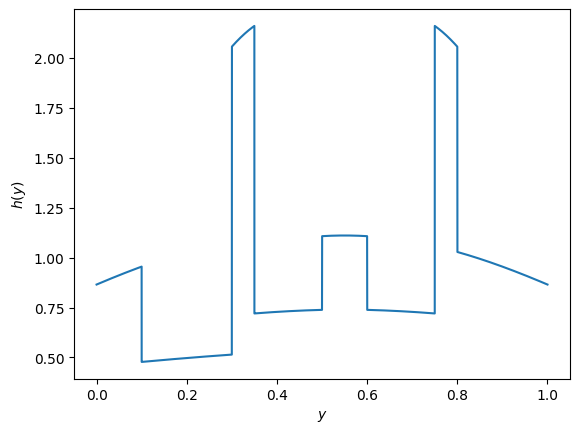

In [ ]:
def h(y, y_params):   #transformed function in accordance with change of variables formula

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct indices
  j_values = torch.clamp((torch.searchsorted(ys, y) - 1), 0, K-1)

  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values+1]
  y_left = ys[j_values]
  y_right = ys[j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac

#test plot
y_test = torch.linspace(1e-10, 1, 10000)
test_h = h(y_test, test_params)
plt.plot(y_test, test_h)
plt.xlabel('$y$')
plt.ylabel('$h(y)$')
plt.show()

In [ ]:
#check integral is preserved
from scipy.integrate import quad, trapezoid

x_int_test, y_int_test = torch.linspace(0, 1, 10000), torch.linspace(0, 1, 1000000)

F_numpy = trapezoid(f(x_int_test).numpy(), x_int_test.numpy())
print("F:", F_numpy)

H_numpy = trapezoid(h(y_int_test, test_params).numpy(), y_int_test.numpy())
print("H:", H_numpy)

F: 0.922562
H: 0.92256206


In [ ]:
#check variances are different in general

f_var = torch.var(f(x_int_test))
h_var = torch.var(h(y_int_test, test_params))

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0045)
H variance: tensor(0.1934)


In [ ]:
#K = 32   #number of bins

#unconstrained parameters
import torch.nn.functional
def u_to_y(u):
  u_ext = torch.cat([u, torch.tensor([0.0])])
  w = torch.nn.functional.softmax(u_ext, dim=0)
  ys = torch.cumsum(w, dim=0)
  return ys[:-1]

#u_params = torch.zeros(K-1, requires_grad=True)


In [ ]:
#optimisation

#can use a training loop, variance is the loss function

x = torch.rand(100000)
#optimiser = torch.optim.Adam([u_params], lr=0.01)
epochs = 1000

def train_loop(x, K, epochs):

  u_params = torch.zeros(K-1, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=0.05)

  for epoch in range(epochs):
    y_params = u_to_y(u_params)
    y = g(x, y_params)
    h_eval = h(y, y_params)

    loss = torch.var(h_eval)

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    #if epoch % 10 == 0:
      #print(f"Epoch: {epoch} | Loss: {loss}")

  return loss

test = train_loop(x, 32, 500)
print(test)

tensor(2.2999e-05, grad_fn=<VarBackward0>)


In [ ]:
#generate data

Ks = range(2, 33)
vars = torch.zeros(len(Ks))
i=0

for K in Ks:
  result = train_loop(x, K, 500)
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

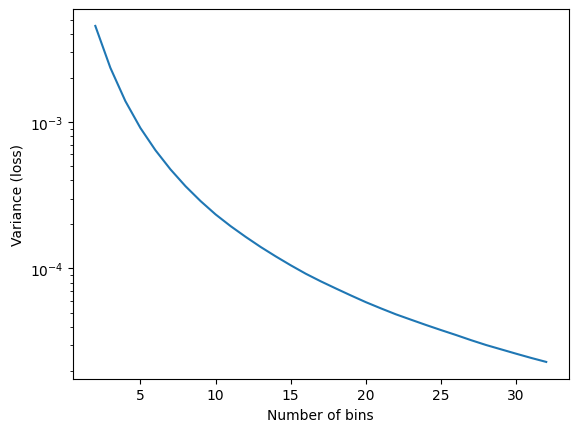

tensor([0.0045, 0.0023, 0.0014], grad_fn=<SliceBackward0>)
tensor(2.2999e-05, grad_fn=<SelectBackward0>)


In [ ]:
#plotting

plt.figure()
plt.plot(Ks, vars.detach().numpy()) # Detach and convert to numpy for plotting
plt.xlabel('Number of bins')
plt.ylabel('Variance (loss)')
plt.yscale('log')
plt.show()
print(vars[0:3])    #check for errors
print(vars[-1])     #check accuracy